In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
pd.set_option('display.max_columns', None)
from rapidfuzz import process, fuzz
from sklearn.feature_selection import RFE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [166]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brand             75930 non-null  object 
 1   model             74252 non-null  object 
 2   price             75973 non-null  int64  
 3   transmission      73710 non-null  object 
 4   mileage           74141 non-null  Int64  
 5   fuelType          74295 non-null  object 
 6   tax               67691 non-null  float64
 7   mpg               68011 non-null  float64
 8   engineSize        74193 non-null  float64
 9   car_age           74124 non-null  Int64  
 10  mileage_per_year  72328 non-null  Float64
dtypes: Float64(1), Int64(2), float64(3), int64(1), object(4)
memory usage: 6.6+ MB


### Missing Data

In [156]:
miss = df_train.isna().sum()
mv = pd.DataFrame({"missing": miss[miss>0], "missing_%": (miss[miss>0]/len(df)*100).round(2)}).sort_values("missing_%", ascending=False)
if not mv.empty:
    print("\nMissing-values summary (non-zero):")
    print(mv.head(20))


Missing-values summary (non-zero):
              missing  missing_%
tax              8282      10.90
mpg              7962      10.48
transmission     2263       2.98
year             1849       2.43
mileage          1832       2.41
engineSize       1780       2.34
model            1721       2.27
fuelType         1678       2.21
brand              43       0.06


**Plan**: Median imputation for numeric, most_frequent for categoricals.

### Feature Engineering

#### car_age

As stated before we created a new variable car_age because it has a more linear relation to depreciation than raw year.

In [157]:
df_train["car_age"] = 2020 - df_train["year"]

We can drop year as from now on we'll be using car_age

In [158]:
df_train = df_train.drop(columns=['year'])

Visualization of new variable car_age

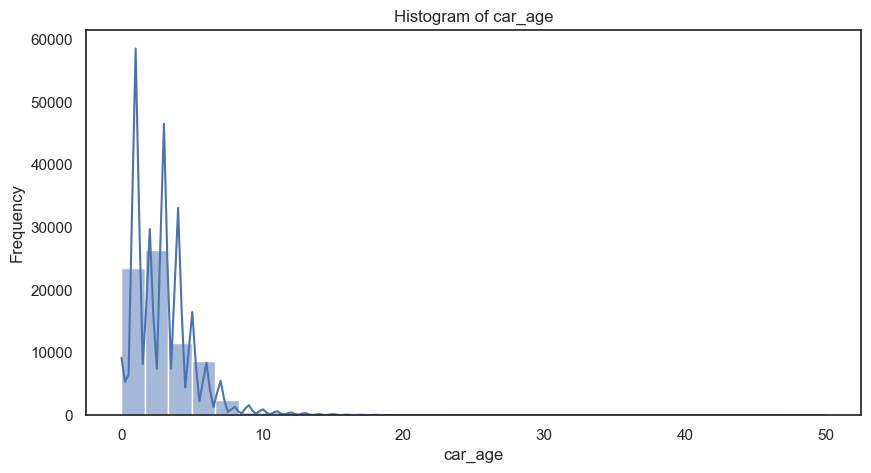

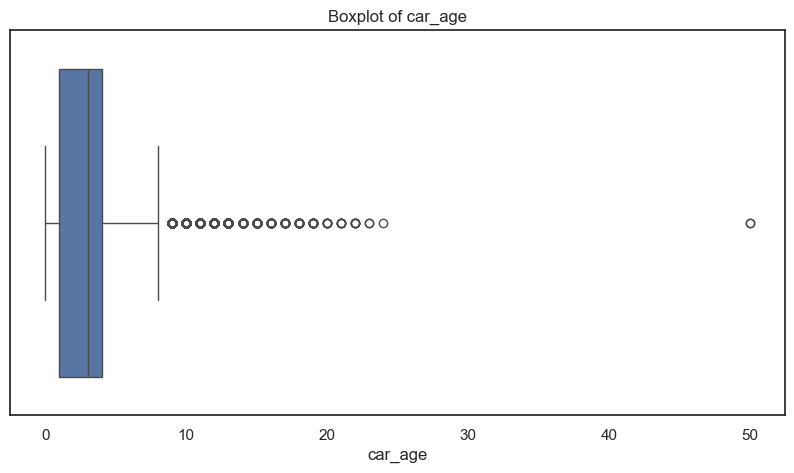

In [159]:
# Histogram.
plt.figure(figsize=(10,5))
sns.histplot(df_train['car_age'], bins=30, kde=True) 
plt.title('Histogram of car_age')
plt.xlabel('car_age')
plt.ylabel('Frequency')
plt.show()

# Boxplot.
plt.figure(figsize=(10,5))
sns.boxplot(x=df_train['car_age'])
plt.title('Boxplot of car_age')
plt.xlabel('car_age')
plt.show()

**Outliers:** 
- The distribution of this variable is highly right skewed with some extreme outliers which give disproportionate leverage to a few samples, hurting linear models and making scaling unstable. 
- The plan is to apply log1p. 
- log1p compresses the long right tail, stabilizes variance, and often linearizes multiplicative

#### mileage_per_year

We created mileage_per_year to capture use-intensity, in order to separate “old but barely used” from “recent but heavily used.”

In [160]:
df_train["mileage_per_year"] = df_train["mileage"] / df_train["car_age"].replace({0: 1})

Visualization of new variable car_age

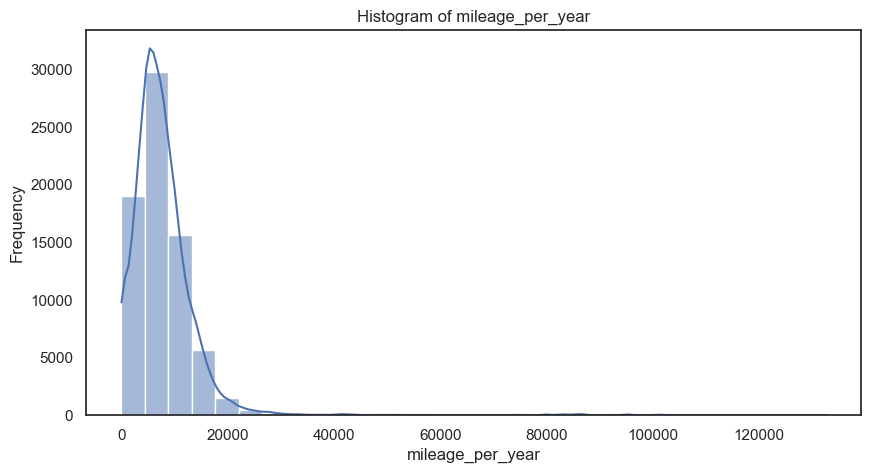

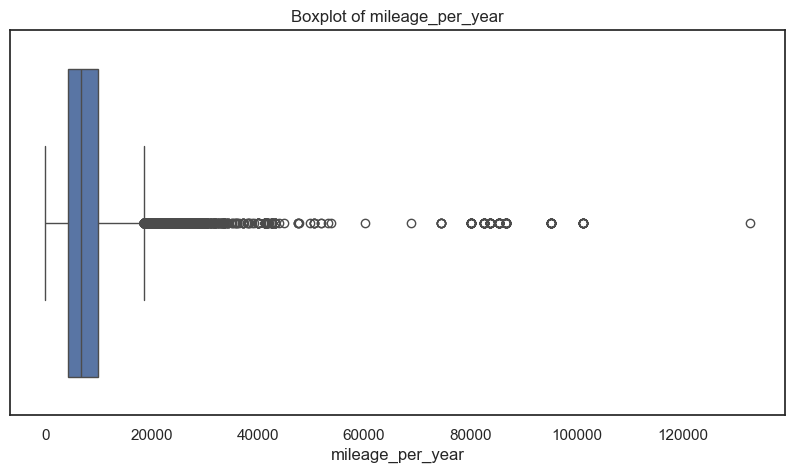

In [161]:
# Histogram.
plt.figure(figsize=(10,5))
sns.histplot(df_train['mileage_per_year'], bins=30, kde=True) 
plt.title('Histogram of mileage_per_year')
plt.xlabel('mileage_per_year')
plt.ylabel('Frequency')
plt.show()

# Boxplot.
plt.figure(figsize=(10,5))
sns.boxplot(x=df_train['mileage_per_year'])
plt.title('Boxplot of mileage_per_year')
plt.xlabel('mileage_per_year')
plt.show()

**Outliers:** 
- The distribution of this variable is highly right skewed with some extreme outliers which give disproportionate leverage to a few samples, hurting linear models and making scaling unstable. 
- The plan is to apply log1p. 
- log1p compresses the long right tail, stabilizes variance, and often linearizes multiplicative

# Model

### Data Scaling | Dealing with Categorical Features | Outliers

In [ ]:
class RareLabelGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, min_prop=0.005, column=None):
        self.min_prop = min_prop
        self.column = column
        self.keep_values_ = None
    def fit(self, X, y=None):
        s = X if isinstance(X, pd.Series) else pd.Series(X.iloc[:,0] if hasattr(X, "iloc") else X[:,0])
        vc = s.value_counts(dropna=False)
        total = len(s)
        keep = vc[vc / total >= self.min_prop].index
        self.keep_values_ = set(keep.tolist())
        return self
    def transform(self, X):
        s = X if isinstance(X, pd.Series) else pd.Series(X.iloc[:,0] if hasattr(X, "iloc") else X[:,0])
        return pd.DataFrame(np.where(s.isin(self.keep_values_), s, "Other"),
                            columns=[self.column if self.column else "col"])

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column): self.column = column
    def fit(self, X, y=None): return self
    def transform(self, X): return pd.DataFrame(X[self.column])

class CustomWinsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, variables, lower_bound=0.01, upper_bound=0.99):
        self.variables = variables
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.limits_ = {}

    def fit(self, X, y=None):
        for var in self.variables:
            if var in X.columns:
                lower_limit = X[var].quantile(self.lower_bound)
                upper_limit = X[var].quantile(self.upper_bound)
                self.limits_[var] = (lower_limit, upper_limit)
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for var, (lower_limit, upper_limit) in self.limits_.items():
            if var in X.columns:
                X_transformed[var] = np.clip(X_transformed[var], lower_limit, upper_limit)
        return X_transformed

In [ ]:
feature_cols = [c for c in df_train.columns if c != "price"]

X = df_train[feature_cols].copy()
y = df_train["price"].copy()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=44, shuffle=True
)

Removing outliers from target variable (price)

In [ ]:
y_train_transformed = np.log1p(y_train)
y_val_transformed = np.log1p(y_val)

Scaling

- **Why scale:** Linear/regularized models are scale-sensitive. Numeric features can have very different ranges (ex: mileage vs engine size), which biases coefficients.

- **Choice:** **StandardScaler** for numeric columns (after imputation and outlier capping).

- **StandardScaler over MinMaxScaler:** Standardization centers and normalizes variance—well-aligned with Ridge/Lasso penalties and keeps One-Hot Enconding interpretable. All scaling is fit on the training fold only within the pipeline to ensure that there are **no leakage**.

In [ ]:
scaler = StandardScaler()

In [ ]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]
without_model = [c for c in X_train.columns if c not in numeric_cols + ['model']]
skewness = X_train[numeric_cols].skew(numeric_only=True).sort_values(ascending=False)
log_candidates = [c for c, s in skewness.items() if np.isfinite(s) and s > 1.0]
log_candidates = [c for c in log_candidates if (X_train[c].dropna() >= 0).all()]
outlier_variable = ['tax']

In [ ]:
def log1p_selective(df_num):
    df_num = pd.DataFrame(df_num, columns=numeric_cols)
    for c in log_candidates:
        df_num[c] = np.log1p(df_num[c])
    return df_num

log_transformer = FunctionTransformer(log1p_selective, validate=False)

numeric_pipeline = Pipeline([('winsor', CustomWinsorizer(variables=outlier_variable, lower_bound=0.01, upper_bound=0.99)), ("imputer", SimpleImputer(strategy="median")),("log1p_skewed", log_transformer), ("scaler", scaler)])

In [ ]:
cats = []
cats.append(("cat",
                 Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                           ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))]),
                without_model))
cats.append(("model_collap",
                 Pipeline([("select", ColumnSelector("model")),
                           ("impute", SimpleImputer(strategy="most_frequent")),
                           ("rare", RareLabelGrouper(min_prop=0.005, column="model")),
                           ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))]),
                 ["model"]))

In [ ]:
preprocessor = ColumnTransformer([("num", numeric_pipeline, numeric_cols), *cats], remainder="drop")

In [ ]:
tmp = Pipeline([("prep", preprocessor)]).fit(X_train, y_train)
n_total = tmp.transform(X_train.iloc[:5]).shape[1]

In [ ]:
n_total

## 5. Feature Selection

Following initial data preprocessing steps, which included the **removal of several irrelevant columns**, we employed **Recursive Feature Elimination (RFE)** to determine the optimal feature subset for our linear regression model. 

A **holdout** validation approach was utilized to evaluate model performance with varying numbers of features, using the **Mean Absolute Error (MAE)** as the primary evaluation metric. 
- This process identified an optimal subset consisting of 66 features.

In [ ]:
grid = np.arange(1,n_total+1)

In [ ]:
records = []
best_model = None
high_score=None
n_feat=0

In [ ]:
for n_sel in grid:
    model = LinearRegression()
    pipe = Pipeline([
        ("prep", preprocessor),
        ("rfe", RFE(estimator=model, n_features_to_select=n_sel)),
        ("linreg", LinearRegression()),
    ])
    pipe.fit(X_train, y_train_transformed)
    pred_log = pipe.predict(X_val)
    pred_original_scale = np.expm1(pred_log)
    mae = mean_absolute_error(y_val, pred_original_scale)
    records.append({"n_selected": n_sel, "MAE": mae})
    score = mae
    if (high_score is None) or (score < high_score):
        high_score = score
        best_model = pipe
df_best = pd.DataFrame(records).sort_values(["MAE"]).reset_index(drop=True)
print("Optimum number of features: %d" % df_best.iloc[0]['n_selected'])
print("Score with %d features: %f" % (df_best.iloc[0]['n_selected'], df_best.iloc[0]['MAE']))

## 6. Model and evaluation

The project focuses on a regression problem with the objective of predicting used car prices. The following ML algorithms were selected for evaluation: 
- **Linear Regression:** Used as a baseline model due to its simplicity and interpretability.
- **Lasso Regression:** Explored for its ability to perform automatic feature selection by driving some coefficients to zero.
- **Decision Tree Regressor:** Implemented to capture potential non-linear relationships and more complex interactions between features, ultimately yielding the best performance.

**Assessment Strategy:** A consistent holdout split with a fixed random_state was maintained throughout the work to ensure reproducibility and avoid data leakage.

We start by implementing the optimal model (for linear regression) identified in the previous section.

In [ ]:
pred_log = best_model.predict(X_val) 
pred_original_scale = np.expm1(pred_log)

#### Metrics

- Primary metric: **MAE**, because it is in price units, offering direct interpretability, and is less sensitive to outliers compared with other metrics (ex:MSE).

- Secondary: **RMSE** (penalizes large errors) and **R²** (variance explained, for context).

In [ ]:
mae = mean_absolute_error(y_val, pred_original_scale)
rmse = mean_squared_error(y_val, pred_original_scale, squared=False)
r2 = r2_score(y_val, pred_original_scale)
print("\n--- Model Performance (Best RFE) ---")
print(f"Main Metric (MAE): {high_score:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

#### Other models

In [ ]:
models_to_test = {
    "Lasso": LassoCV(cv=5, random_state=44),
    "DecisionTree": DecisionTreeRegressor(random_state=44)
}

high_score_2 = None
best_model_2 = None
best_model_2_name = ""
records = []

for name, model in models_to_test.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model),
    ])

    pipe.fit(X_train, y_train_transformed)
    pred_log = pipe.predict(X_val)    
    pred_original_scale = np.expm1(pred_log)

    #metrics
    mae = mean_absolute_error(y_val, pred_original_scale)
    rmse = mean_squared_error(y_val, pred_original_scale, squared=False)
    r2 = r2_score(y_val, pred_original_scale)

    records.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

    if (high_score_2 is None) or (mae < high_score_2):
        high_score_2 = mae
        best_model_2 = pipe
        best_model_2_name = name

print("Results for all models:")
results_df = pd.DataFrame(records).sort_values(by="MAE").reset_index(drop=True)
print(results_df)

print(f"Best model: {best_model_2_name}")
print(f"MAE metric for the best model: {high_score_2:.4f}")

In [ ]:
pred_log = best_model_2.predict(X_val) 
pred_original_scale = np.expm1(pred_log)

#### Plot some visualizations

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=pred_original_scale, alpha=0.6)
lims = [min(y_val.min(), pred_original_scale.min()), max(y_val.max(), pred_original_scale.max())]
plt.plot(lims, lims, color='red', linestyle='--', linewidth=2)

plt.title('Actual vs Predicted Car price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

In [ ]:
residuals = y_val - pred_original_scale

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pred_original_scale, y=residuals, alpha=0.6)

plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.title('Residuals vs Predicted Car Prices')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=50)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#Export the best model for use in test.csv dataset
#joblib.dump(best_model_2, 'best_model')